# Week 5 — Predict2Optimize

This week is about **putting everything together**.

You will run a portfolio *over time* by combining: prediction, optimization, and backtesting.

There is no single correct solution here! Still some pointers are given.

---

## The loop

> predict returns → optimize portfolio → hold → rebalance → repeat

---

## What you need to do (roughly)

1. **Choose assets and dates**  
   Use a small set of tickers and a reasonable time range.

2. **Build a predictor**  
   Estimate $\hat\mu_t, \hat\Sigma_t$ using past returns only.

   Stick to an easy model - linear predictor for returns, and simple rolling covariance estimate for covariance matrix.

3. **Set a baseline**  
   Examples: 1/N portfolio, or GMVP etc.

4. **Reuse your optimizer**  
   Use your Week 4 Markowitz optimizer.

5. **Write a strategy function**  
   Takes time `t`, past returns, previous weights -> returns new weights. See the howto.

6. **Run the backtest**  
   Choose rebalancing frequency and transaction costs.

7. **Plot diagnostics**
    * Net wealth
    * Daily returns
    * Portfolio weights
    * Turnover
    * ... feel free to extend this, perhaps track the free cash as well?

    > Compare against your baseline.

---

## Common pitfalls

* **Look-ahead bias**
* **Too-frequent rebalancing**
* **Overtrusting predictions**
    - assume some simple uncertainty set and use robust optimization!

---

## Bonus ideas (optional)

* Transaction-cost-aware optimizer (see last bonus section in [howto.ipynb](howto.ipynb))
* Weekly vs monthly rebalancing
* Robust Markowitz
* Rolling Sharpe ratio

---

That’s it. Build a portfolio using the tools you wrote (and the helpers :D)!

Optimize away!
---

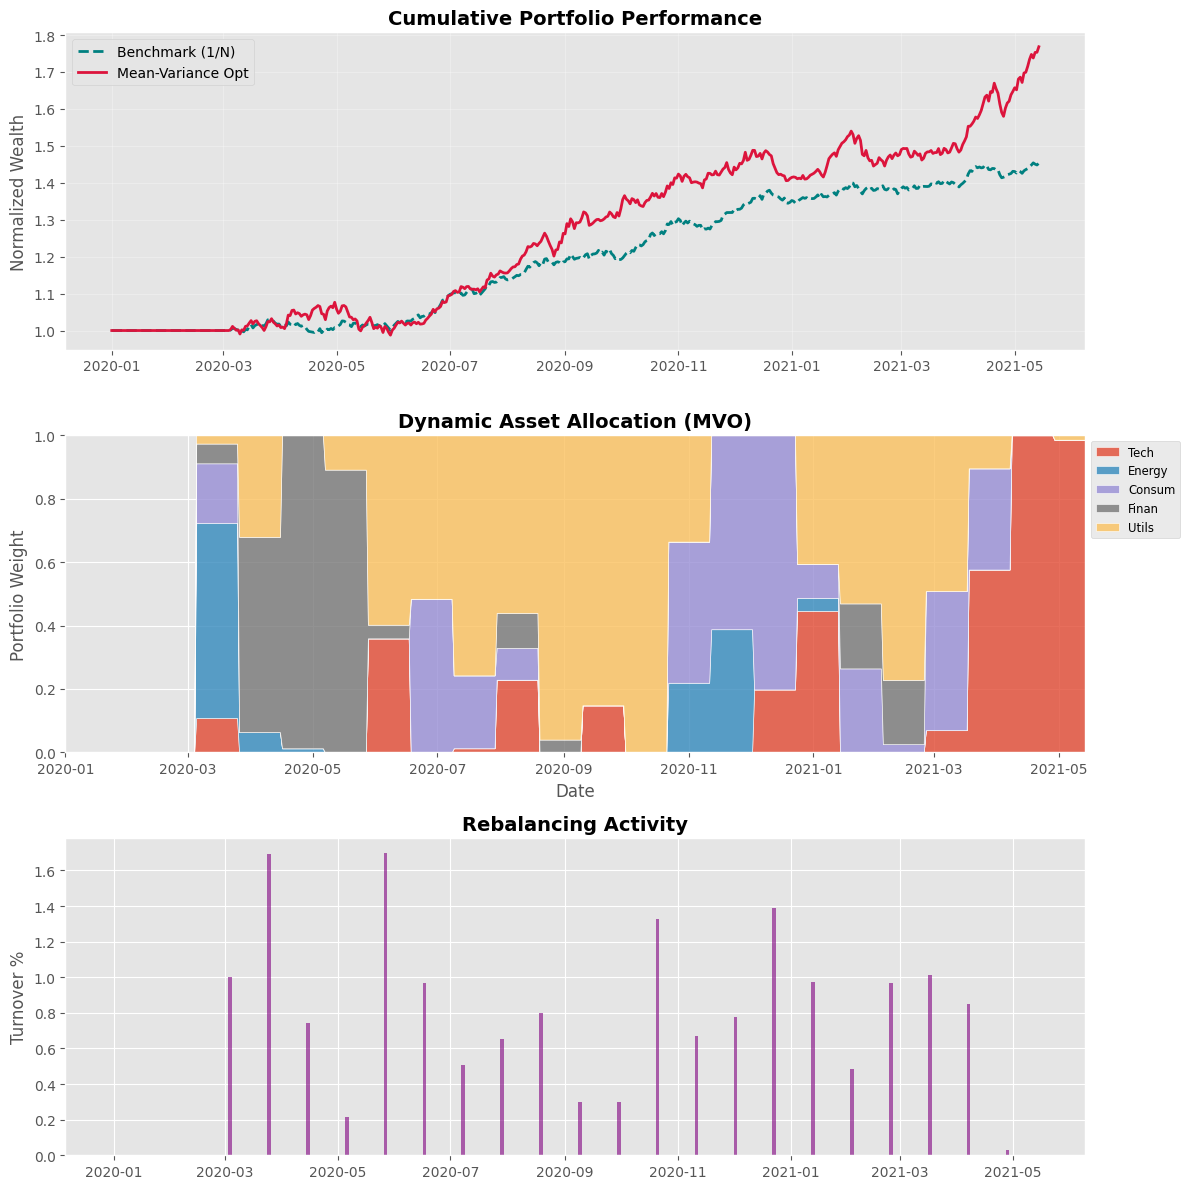

Final MVO Return: 76.83%


In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd

def calc_asset_metrics(data_slice, regularization=1e-3):
    """Calculates mean returns and covariance matrix with regularization."""
    expected_returns = data_slice.mean(axis=0)
    risk_matrix = np.cov(data_slice, rowvar=False)
    risk_matrix = (risk_matrix + risk_matrix.T) / 2
    risk_matrix += regularization * np.eye(risk_matrix.shape[0])
    return expected_returns, risk_matrix

def optimize_mean_variance(exp_ret, risk_mat, risk_aversion=1.0):
    """Solves the convex optimization problem for portfolio weights."""
    n_assets = exp_ret.shape[0]
    weights = cp.Variable(n_assets)
    portfolio_risk = cp.quad_form(weights, risk_mat)
    objective = cp.Maximize(exp_ret @ weights - risk_aversion * portfolio_risk)
    constraints = [cp.sum(weights) == 1, weights >= 0]
    problem = cp.Problem(objective, constraints)
    try:
        problem.solve(solver=cp.OSQP, verbose=False)
    except cp.error.SolverError:
        problem.solve(solver=cp.SCS, verbose=False)
    if weights.value is None:
        return None
    return np.array(weights.value).flatten()

def strategy_equal_weight(step_idx, return_matrix, previous_weights):
    num_assets = return_matrix.shape[1]
    return np.ones(num_assets) / num_assets

def strategy_mvo(step_idx, return_matrix, previous_weights, lookback=60, penalty=1.0):
    history_window = return_matrix[step_idx - lookback : step_idx]
    
    mu, sigma = calc_asset_metrics(history_window)
    optimal_w = optimize_mean_variance(mu, sigma, risk_aversion=penalty)
    if optimal_w is None or np.isnan(optimal_w).any():
        if np.sum(previous_weights) <= 0:
            n = return_matrix.shape[1]
            return np.ones(n) / n
        return previous_weights
    optimal_w = np.clip(optimal_w, 0, None)
    return optimal_w / optimal_w.sum()

def run_portfolio_simulation(
    returns_data,
    date_index,
    initial_funding,
    strategy_func,
    lookback_window=60,
    rebal_interval=21,
    tx_cost=0.0
):
    """
    Simulates portfolio performance over time.
    """
    matrix = np.asarray(returns_data)
    total_steps, n_assets = matrix.shape
    equity_curve = np.zeros(total_steps)
    cash_holdings = np.zeros(total_steps)
    daily_pnl = np.zeros(total_steps)
    turnover_volume = np.zeros(total_steps)
    allocation_history = np.zeros((total_steps, n_assets))
    equity_curve[: lookback_window + 1] = initial_funding
    cash_holdings[: lookback_window + 1] = initial_funding
    active_weights = np.zeros(n_assets)
    for step in range(lookback_window, total_steps - 1):
        
        transaction_fee = 0.0
        if step % rebal_interval == 0:
            target_weights = strategy_func(step, matrix, active_weights)
            weight_diff = np.abs(target_weights - active_weights).sum()
            transaction_fee = tx_cost * weight_diff * equity_curve[step]
            active_weights = target_weights
            turnover_volume[step] = weight_diff
            cash_holdings[step] -= transaction_fee
            
        period_return = np.dot(active_weights, matrix[step + 1])
        daily_pnl[step + 1] = period_return
        growth_factor = 1 + period_return
        equity_curve[step + 1] = (equity_curve[step] * growth_factor) - transaction_fee
        cash_holdings[step + 1] = (cash_holdings[step] * growth_factor) - transaction_fee
        allocation_history[step + 1] = active_weights
        
    return pd.DataFrame({
        "Date": date_index,
        "Total_Equity": equity_curve,
        "Daily_Return": daily_pnl,
        "Turnover": turnover_volume
    }), allocation_history

try:
    returns_matrix = returns_df.values
    dates_list = returns_df.index
    asset_names = list(returns_df.columns)
except NameError:
    np.random.seed(42)
    asset_names = ["Tech", "Energy", "Consum", "Finan", "Utils"]
    dates_list = pd.date_range(start="2020-01-01", periods=500)
    returns_matrix = np.random.normal(0.0005, 0.01, (500, 5)) 

# Parameters
LOOKBACK = 60
REBAL_FREQ = 21
COST_BPS = 0.001
RISK_LAMBDA = 1.0

df_ew, weights_ew = run_portfolio_simulation(
    returns_data=returns_matrix,
    date_index=dates_list,
    initial_funding=1.0,
    strategy_func=lambda t, r, w: strategy_equal_weight(t, r, w),
    lookback_window=LOOKBACK,
    rebal_interval=REBAL_FREQ,
    tx_cost=COST_BPS
)

df_mvo, weights_mvo = run_portfolio_simulation(
    returns_data=returns_matrix,
    date_index=dates_list,
    initial_funding=1.0,
    strategy_func=lambda t, r, w: strategy_mvo(t, r, w, LOOKBACK, RISK_LAMBDA),
    lookback_window=LOOKBACK,
    rebal_interval=REBAL_FREQ,
    tx_cost=COST_BPS
)

plt.style.use('ggplot') 
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=False)

# Plot 1: Wealth Curves
ax1 = axes[0]
ax1.plot(df_ew["Date"], df_ew["Total_Equity"], label="Benchmark (1/N)", color='teal', linewidth=2, linestyle='--')
ax1.plot(df_mvo["Date"], df_mvo["Total_Equity"], label="Mean-Variance Opt", color='crimson', linewidth=2)
ax1.set_title("Cumulative Portfolio Performance", fontsize=14, fontweight='bold')
ax1.set_ylabel("Normalized Wealth")
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)

# Plot 2: Asset Allocation (Stacked Area) for MVO
ax2 = axes[1]
ax2.stackplot(df_mvo["Date"], weights_mvo.T, labels=asset_names, alpha=0.8, edgecolors='white')
ax2.set_title("Dynamic Asset Allocation (MVO)", fontsize=14, fontweight='bold')
ax2.set_ylabel("Portfolio Weight")
ax2.set_xlabel("Date")
ax2.margins(0, 0)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Plot 3: Turnover (Trading Activity)
ax3 = axes[2]
ax3.bar(df_mvo["Date"], df_mvo["Turnover"], color='purple', alpha=0.6, label='Turnover', width=2)
ax3.set_title("Rebalancing Activity", fontsize=14, fontweight='bold')
ax3.set_ylabel("Turnover %")

plt.tight_layout()
plt.show()

total_ret_mvo = (df_mvo["Total_Equity"].iloc[-1] / df_mvo["Total_Equity"].iloc[0]) - 1
print(f"Final MVO Return: {total_ret_mvo:.2%}")